<a href="https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Labs/lab4/lab4_parte2.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab4
configure_lab4()
from lab4 import *
GRADER = part_2()

--2020-11-17 19:57:14--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14117 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  13.79K  --.-KB/s    in 0.001s  

2020-11-17 19:57:14 (17.6 MB/s) - ‘general.py’ saved [14117/14117]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 4 - Parte 2

En este laboratorio vamos analizar el efecto del sobre-ajuste (*over-fitting*), como identificarlo y como podemos regualizar los modelos para evitarlo o disminuir su efecto. 

En este laboratorio, vamos a enfocarnos en 2 modelos (usando libreria de sklearn): 

1. Regresión logistica 
2. MLP

**No vamos enfocarnos en como tratar la maldición de la dimensionalidad** ya que esto lo vamos a ver un poco más adelante cuando evaluemos las tecnicas de selección de caracteristicas.

Vamos usar [el dataset de digitos escritos a mano](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) para realizar nuestra practica.

In [2]:
x,y = load_digits(return_X_y=True)

Una de las condiciones para que se presente sobre-ajustes es tener un conjunto de entrenamiento pequeño. 

En nuestra practica vamos a simular esta condición para ver que tecnicas podemos usar para reducir el efecto del sobre-ajuste. 

**Nota**
1. En un problema real, si se observa que las medidas de rendimiento no llegan satisfacen las necesidades, la respuesta puede ser que se necesitan más datos en el conjunto de entrenamiento.


In [3]:
# simular conjunto de datos pequeño
x, x_test, y, y_test = train_test_split(
    x, y, test_size=0.6, random_state=10)
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

In [4]:
print(x.shape)
print(y.shape)

(718, 64)
(718,)


## Ejercicio 1 - Detectar sobre ajuste

En nuestro primer ejercicio vamos a entrenar un MLP con una arquitectura especifica, pero:
1. usaremos cross validación.
2. calcular error de entrenamiento y prueba
3. la función recibe de manera arbitraria un estimador de sklearn
4. [usar accuracy score como medida de rendimiento](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [5]:
# ejercicio de código
def diff_train_test(sklearnModel, Xtrain, Ytrain, Xtest, Ytest):
    """función que retorna error de entrenamiento
    sklearnModel: objeto estimador de sklearn ya entrenado
    X: matriz numpy con las caracteristicas
    Y: vector de numpy con las etiquetas
    
    retorna: tuple con tres elementos:
        error entrenamiento, error test y 
        diff entre error y test
    """


    error_train = accuracy_score(y_true =Ytrain, y_pred = sklearnModel.predict(Xtrain ) )
    error_test = accuracy_score(y_true=Ytest , y_pred = sklearnModel.predict( Xtest))
    diff = error_test - error_train
    return (error_train, error_test, diff)
        

In [6]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", diff_train_test)

TEST EXITOSO!


Con la función construida, vamos a usarla para verificar la differencia entre el error de entrenamiento y prueba para los dos modelos que vamos a usar:
1. MLP con dos capas, cada una con 64 neuornas. `random_state=1` es usado para lograr tener los mismos resultados siempre
2. [Regresión logistica forzada para que no use ninguna regularización](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). `random_state=1` es usado para lograr tener los mismos resultados

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=[20,20], max_iter=500, alpha =1e-6, random_state=1)
mlp.fit(x, y)
# aca usamos el * para pasa cada elemento como argumento 
print("MLP entrenamiento:{0:.3f}, test:{1:.3f} y diff {2:.3f}".format(*diff_train_test(mlp,x,y, x_test, y_test)))

MLP entrenamiento:1.000, test:0.943 y diff -0.057


In [8]:
reg = LogisticRegression(penalty='none', max_iter=500,  random_state=1)
reg.fit(x, y)
print("Logistic Regresion entrenamiento:{0:.3f}, test:{1:.3f} y diff {2:.3f}".format(*diff_train_test(reg,x,y, x_test, y_test)))

Logistic Regresion entrenamiento:1.000, test:0.930 y diff -0.070


## Ejercicio 2 - Experimentar con MLP regularizado

Vamos a comenzar regularizar el modelo, el primer metodo que vamos a usar es el de parada anticipada (*early-stopping*). Este ya se encuentra implementado dentro de la libreria, vamos a experimentar con este parametro y el el numero de neuronas en el MLP.

In [9]:
#@title Pregunta Abierta
#@markdown ¿Explique en sus palabras a que corresponde el metodo de parada anticipada?
respuesta_1 = " Consiste en evaluar el error del modelo en cada iteracion con el conjunto de validacion y el conjunto de entrenamiento, asi que la idea es detener el entrenamiento del modelo cuando el error con el conjunto de validacion en vez de disminuir empieza a aumentar. Se detiene apesar de que el error con el conjunto de entrenamiento siga disminuyendo" #@param {type:"string"}

In [10]:
#@title Pregunta Abierta
#@markdown ¿basandose en la documentación de sklearn para MLPClassifier que relación tiene el parametro validation_fraction con la parada anticipada?
respuesta_2 = "Es la proporcion de  datos del conjunto de entrenamiento que se van a reservar como conjunto de validacion, para la oportuna detencion de la para anticipada" #@param {type:"string"}

In [11]:
  # ejercicio de código
def exp_mlp_early_stop(Xtrain,Xtest,Ytrain, Ytest, num_neurons, is_early_stop):
    """ función para realizar experimentos con el MLP con early stopping
    Xtrain: matriz de numpy con caracteristicas de entrenamiento
    Xtest: matriz de numpy con caracteristicas de prueba
    ytrain: vector numpy con etiqueta de entrenamiento
    ytest: vector numpy con etiqueta de prueba
    num_neurons: list de enteros con el numero de neuronas a usar
    is_early_stop: list de boolean para confirmar si se aplica early stop
    
    Retorna: dataframe con 5 columnas:
        - numero de neuronas
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba  
    """
    resultados = pd.DataFrame()
    idx = 0
    for early_stop in is_early_stop:
        for neurons in num_neurons:
            #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
            # prestar atención a los parametros, correctos.
            hidden_layer_sizes = tuple(2*[neurons])
            # llame el parametro que el MLP pare anticipadamente
            mlp = MLPClassifier(hidden_layer_sizes= hidden_layer_sizes, max_iter = 1000,random_state=1, early_stopping=early_stop )
            # entrenar
            mlp.fit(X= Xtrain, y=Ytrain)
            # llamar la funcion creada anteriomente
            error_train, error_test, diff = diff_train_test(mlp, Xtrain, Ytrain, Xtest, Ytest)

            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error de entrenamiento'] = error_train
            resultados.loc[idx,'error de prueba'] = error_test
            resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
            resultados.loc[idx,'is_early_stop'] = early_stop
            idx+=1
    return (resultados)

In [12]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", exp_mlp_early_stop)

TEST EXITOSO!


In [13]:
res_early_stop = exp_mlp_early_stop(x, x_test, y, y_test, [8,16,20,24], [True, False])

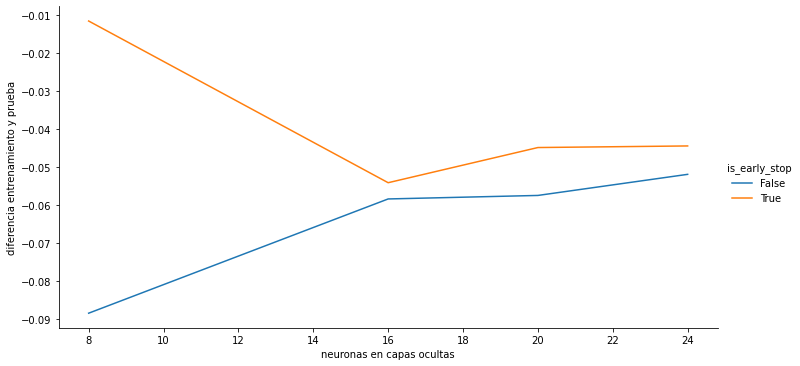

In [14]:
import seaborn as sns
sns.relplot(x = 'neuronas en capas ocultas', y='diferencia entrenamiento y prueba', hue = 'is_early_stop', data = res_early_stop, kind = 'line', aspect=2)

Ahora vamos a experimentar con el parametro L2 del MLP.

In [15]:
#@title Pregunta Abierta
#@markdown ¿explique en sus palabras en qué consiste la regularización L2?
respuesta_3 = "Es un tipo de regularizacion en donde el termino adicional que se ubica en la funcion de costo, calcula la magnitud al cuadrado de los pesos. De esta manera controla la complejidad del modelo\"" #@param {type:"string"}

In [16]:
# ejercicio de código
def exp_mlp_l2(Xtrain,Xtest,Ytrain, Ytest, num_neurons, l2_values):
    """ función para realizar experimentos con el MLP con early stopping
    Xtrain: matriz de numpy con caracteristicas de entrenamiento
    Xtest: matriz de numpy con caracteristicas de prueba
    ytrain: vector numpy con etiqueta de entrenamiento
    ytest: vector numpy con etiqueta de prueba
    num_neurons: list de enteros con el numero de neuronas a usar
    l2: list de floats con valores para regularizacion l2
    
    Retorna: dataframe con 5 columnas:
        - numero de neuronas
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba  
    """
    resultados = pd.DataFrame()
    idx = 0
    for l2 in l2_values:
        for neurons in num_neurons:
            #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
            # prestar atención a los parametros, correctos.
            hidden_layer_sizes = tuple(2*[neurons])
            # llame el parametro adecuado del MLPClassifier
            mlp = MLPClassifier(hidden_layer_sizes= hidden_layer_sizes, max_iter = 1000, random_state=1, alpha= l2)
            mlp.fit(X=Xtrain, y=Ytrain)
            # llamar la funcion creada anteriomente
            error_train, error_test, diff = diff_train_test(mlp, Xtrain, Ytrain, Xtest, Ytest)
            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error de entrenamiento'] = error_train
            resultados.loc[idx,'error de prueba'] = error_test
            resultados.loc[idx,'diferencia entrenamiento y prueba'] =  diff
            resultados.loc[idx,'l2'] = l2
            idx+=1
    return (resultados)

In [17]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", exp_mlp_l2)

TEST EXITOSO!


In [18]:
res_l2 = exp_mlp_l2(x, x_test, y, y_test, [8,16,20,24], [1e-6,1e-3,1e-1,1e0, 1e1])

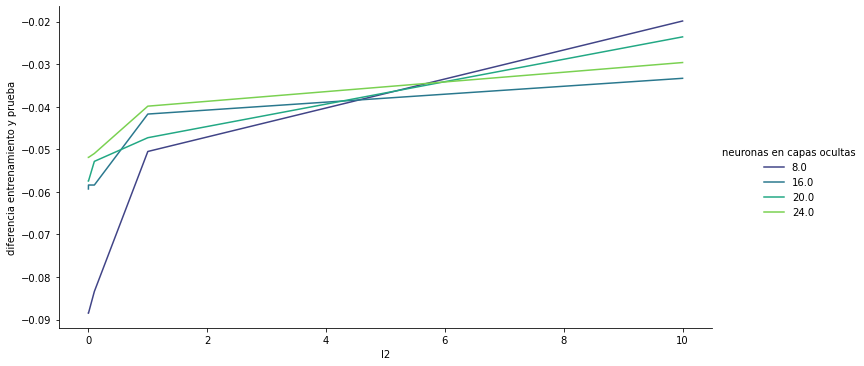

In [19]:
sns.relplot(x = 'l2', y='diferencia entrenamiento y prueba',
            hue = 'neuronas en capas ocultas', 
            data = res_l2, kind = 'line', 
            aspect=2, palette=sns.color_palette('viridis', n_colors=res_l2['neuronas en capas ocultas'].nunique()))

In [20]:
#@title Pregunta Abierta
#@markdown ¿qué efecto tiene el L2 en el overfitting/sobre-ajuste? explique
respuesta_4 = "\"Castiga la complejidad del modelo, siguiendo el principio de regularizacion. Es decir al aumentar el valor de L2, la diferencia entre el entrenamiento y prueba deja de acercarse a cero de manera tan rapida como cuando el valor de l2 era muy pequeno. Por lo tanto a mayor valor de l2 mas se controla el sobreajuste" #@param {type:"string"}

## Ejercicio 3 - Experimentar con regresión logistica regularizada

Ahora vamos explorar la opciones de regularización de la regresión logistica. En la libreria se implementan más formas de regularizar, pero solo vamos a comprobar la regularización de norma L2.

In [21]:
  # ejercicio de código
def exp_reg_l2(Xtrain,Xtest,Ytrain, Ytest, l2_values):
    """ función para realizar experimentos con el MLP con early stopping
    Xtrain: matriz de numpy con caracteristicas de entrenamiento
    Xtest: matriz de numpy con caracteristicas de prueba
    ytrain: vector numpy con etiqueta de entrenamiento
    ytest: vector numpy con etiqueta de prueba
    l2: list de floats con valores para regularizacion l2
    
    Retorna: dataframe con 5 columnas:
        - numero de neuronas
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba  
    """
    resultados = pd.DataFrame()
    idx = 0
    for l2 in l2_values:
        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        # prestar atención a los parametros, correctos., para lograr
        # la regularizacion deseada (pasar el valor de "l2" directamente al parametro de la libreria asociado)
        reg = LogisticRegression(max_iter = 500, random_state=1, C=l2)
        reg.fit(X=Xtrain, y=Ytrain)
        # llamar la funcion creada anteriomente
        error_train, error_test, diff = diff_train_test(reg, Xtrain, Ytrain, Xtest, Ytest)
        resultados.loc[idx,'error de entrenamiento'] = error_train
        resultados.loc[idx,'error de prueba'] = error_test
        resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
        resultados.loc[idx,'l2'] = l2
        idx+=1
    return (resultados)

In [22]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio4", exp_reg_l2)

TEST EXITOSO!


In [23]:
reg_l2 = exp_reg_l2(x, x_test, y, y_test, [1e-6,1e-3,1e-1,1e0, 1e1])

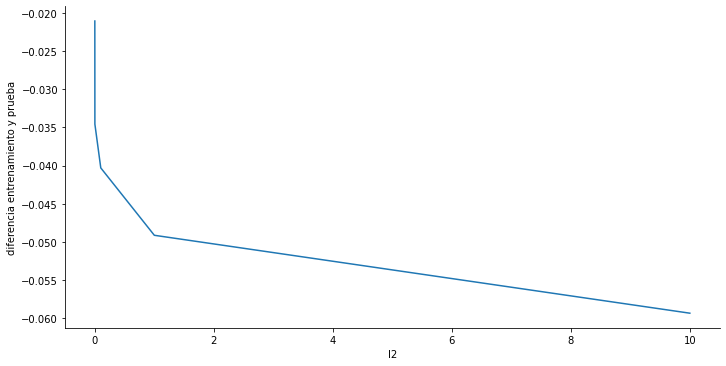

In [24]:
sns.relplot(x = 'l2', y='diferencia entrenamiento y prueba',
             data = reg_l2, kind = 'line', 
            aspect=2)

In [25]:
#@title Pregunta Abierta
#@markdown ¿qué efecto tiene el parametro que controla L2 en la regresión logistica en el overfitting? es diferente al MLP?
respuesta_5 = "A mayor valor l2, se controla menos el sobreajuste y en MLP pasa todo lo contrario, a mayor valor de L2 a mayor valor de l2 mas se controla el sobreajuste" #@param {type:"string"}

## Ejercicio 4 Efecto del tamaño del conjunto de entrenamiento

Finalmente como mencionamos anteriormente, en los ejercicios que hemos resuelto, estabamos simulando la situación de un conjunto de datos de entrenamiento pequeño. En nuestro ultimo ejercicio vamos comprobar el efecto del tamaño del conjunto de entrenamiento.

In [26]:
# ejercicio de codigo
def train_size_experiments(sk_estimator, train_pcts,X,Y):
    """funcion que realiza experimentos para
        comprobar la influencia del tamaño de conjunto
        de entrenamiento.
    
    sk_estimator: estimador/modelo de sklearn definido (sin entrenar)
    train_pcts: lista de floats con los pct de entrenamiento a evaluar
    X: matriz de numpy del conjunto de caracteristicas
    Y: vector numpy con las etiquetas
    
    Retorna: dataframe con 5 columnas:
        - tamaño del conjunto de entrenamiento (porcentaje!)
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba 
    """
    resultados = pd.DataFrame()
    idx = 0
    for train_pct in train_pcts:
        #complete el con train_pct
        # preste atencion a que parametro usar!
        # recuerde que son porcentajes

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=10, train_size=train_pct)
        # normalizamos
        scaler = StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        # entrenar!
        sk_estimator.fit(X=Xtrain, y=Ytrain)
        # llamar la funcion creada anteriomente
        error_train, error_test, diff = diff_train_test(sk_estimator, Xtrain, Ytrain, Xtest, Ytest)
        resultados.loc[idx,'error de entrenamiento'] = error_train
        resultados.loc[idx,'error de prueba'] = error_test
        resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
        # complete con el tamaño del entrenamiento
        resultados.loc[idx,'tamaño de entrenamiento'] = Xtrain.shape[0]
        idx+=1
    
    return (resultados)
    

In [27]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio5", train_size_experiments)

TEST EXITOSO!


In [28]:
# debemos recargar nuestro conjunto de datos
x,y = load_digits(return_X_y=True)

In [29]:
# comprobamos con un MLP
mlp = MLPClassifier(hidden_layer_sizes=[20,20], max_iter=500, random_state=1)
train_size_exp = train_size_experiments(mlp, [0.2,0.3,0.5,0.7,0.9], x, y)

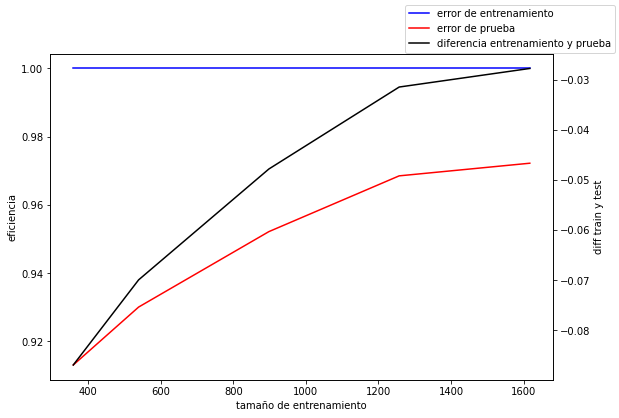

In [30]:
# vemos las tres medidas
ax = train_size_exp.plot(x="tamaño de entrenamiento", y="error de entrenamiento", color="b", legend=False, figsize = (9,6))
train_size_exp.plot(x="tamaño de entrenamiento", y="error de prueba",  ax=ax, legend=False, color="r")
ax2 = ax.twinx()
ax2.set_ylabel("diff train y test")
ax.set_ylabel("eficiencia")
train_size_exp.plot(x="tamaño de entrenamiento", y="diferencia entrenamiento y prueba", ax=ax2, legend=False, color="k")
ax.figure.legend(loc = 'best')
plt.show()

**Notas Finales ** 

Para tener en cuenta: [Sklearn hay una libreria que realiza algo similar a lo que creamos en el anterior ejercicio.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)

Debemos notar que en esta practica exageramos algunas situaciones para lograr medir y ver el efecto del sobre-ajuste. En la practica un flujo de trabajo mas ideal es el siguiente:

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" alt="grid_search_workflow" width="500"/>


1. dividimos el conjunto al inicio, reservando un conjunto de test. 
2. verificamos los mejores parametros mediante validación cruzada. 
3. reentrenamos con los mejores parametros y realizamos la evaluación final. 
4. En esta última etapa es donde validamos si existe sobre ajuste. Si existe, se deben incluir parametros para mitigar el sobre ajuste en la validación cruzada y volver al paso 2.

In [34]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia e archivo al formulario ¡buen trabajo!


In [32]:
#@title Integrantes
codigo_integrante_1 ='1017251689' #@param {type:"string"}
codigo_integrante_2 = ''  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [33]:
GRADER.grade()

uso del docente
